In [4]:
# Import PyTorch libraries
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F

# Other libraries we'll use
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

print("Libraries imported - ready to use PyTorch", torch.__version__)

Libraries imported - ready to use PyTorch 2.6.0+cu124


In [5]:
# The images are in the data/shapes folder
data_path = 'shapes_data/'

# # Get the class names
# classes = os.listdir(data_path)
# classes.sort()
# print(len(classes), 'classes:')
# print(classes)

# # Show the first image in each folder
# fig = plt.figure(figsize=(8, 12))
# i = 0
# for sub_dir in os.listdir(data_path):
#     i+=1
#     img_file = os.listdir(os.path.join(data_path,sub_dir))[0]
#     img_path = os.path.join(data_path, sub_dir, img_file)
#     img = mpimg.imread(img_path)
#     a=fig.add_subplot(1, len(classes),i)
#     a.axis('off')
#     imgplot = plt.imshow(img)
#     a.set_title(img_file)
# plt.show()

In [6]:
# # Function to ingest data using training and test loaders
# def load_dataset(data_path):
#     # Load all of the images
#     transformation = transforms.Compose([
#         # transform to tensors
#         transforms.ToTensor(),
#         # Normalize the pixel values (in R, G, and B channels)
#         transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
#     ])

#     # Load all of the images, transforming them
#     full_dataset = torchvision.datasets.ImageFolder(
#         root=data_path,
#         transform=transformation
#     )
    
    
#     # Split into training (70% and testing (30%) datasets)
#     train_size = int(0.7 * len(full_dataset))
#     test_size = len(full_dataset) - train_size
#     train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])
    
#     # define a loader for the training data we can iterate through in 50-image batches
#     train_loader = torch.utils.data.DataLoader(
#         train_dataset,
#         batch_size=50,
#         num_workers=0,
#         shuffle=False
#     )
    
#     # define a loader for the testing data we can iterate through in 50-image batches
#     test_loader = torch.utils.data.DataLoader(
#         test_dataset,
#         batch_size=50,
#         num_workers=0,
#         shuffle=False
#     )
        
#     return train_loader, test_loader


# # Get the iterative dataloaders for test and training data
# train_loader, test_loader = load_dataset(data_path)
# print('Data loaders ready')

In [7]:
class PyTorchCNN(nn.Module):
    # Constructor
    def __init__(self, num_classes=3):
        super(PyTorchCNN, self).__init__()
        
        # Our images are RGB, so input channels = 3. We'll apply 12 filters in the first convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=1)
        
        # We'll apply max pooling with a kernel size of 2
        self.pool = nn.MaxPool2d(kernel_size=2)
        
        # A second convolutional layer takes 12 input channels, and generates 12 outputs
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=3, stride=1, padding=1)
        
        # A third convolutional layer takes 12 inputs and generates 24 outputs
        self.conv3 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=1, padding=1)
        
        # A drop layer deletes 20% of the features to help prevent overfitting
        self.drop = nn.Dropout2d(p=0.2)
        
        # Our 128x128 image tensors will be pooled twice with a kernel size of 2. 128/2/2 is 32.
        # So our feature tensors are now 32 x 32, and we've generated 24 of them
        # We need to flatten these and feed them to a fully-connected layer
        # to map them to  the probability for each class
        self.fc = nn.Linear(in_features=32 * 32 * 24, out_features=num_classes)

    def forward(self, x):
        # Use a relu activation function after layer 1 (convolution 1 and pool)
        x = F.relu(self.pool(self.conv1(x)))
      
        # Use a relu activation function after layer 2 (convolution 2 and pool)
        x = F.relu(self.pool(self.conv2(x)))
        
        # Select some features to drop after the 3rd convolution to prevent overfitting
        x = F.relu(self.drop(self.conv3(x)))
        
        # Only drop the features if this is a training pass
        x = F.dropout(x, training=self.training)
        
        # Flatten
        x = x.view(-1, 32 * 32 * 24)
        # Feed to fully-connected layer to predict class
        x = self.fc(x)
        # Return log_softmax tensor 
        return F.log_softmax(x, dim=1)
    
print("CNN model class defined!")

CNN model class defined!


## Use the trained model

Now that we've trained and evaluated our model, we can use it to predict classes for new images.

circle


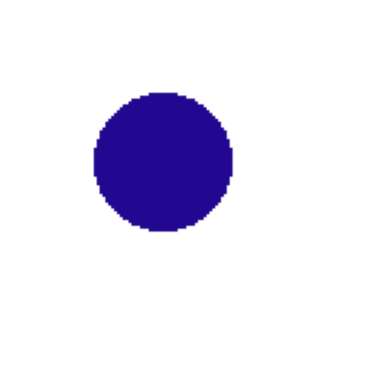

In [10]:
data_path = 'shapes_data/'
model_file = 'shape_cnn/shape_classifier.pt'

# Get the class names
classes = os.listdir(data_path)
classes.sort()


import matplotlib.pyplot as plt
import os
from random import randint
%matplotlib inline


# Function to predict the class of an image
def predict_image(classifier, image):
    import numpy
    
    # Set the classifer model to evaluation mode
    classifier.eval()
    
    # Apply the same transformations as we did for the training images
    transformation = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    # Preprocess the image
    image_tensor = transformation(image).float()

    # Add an extra batch dimension since pytorch treats all inputs as batches
    image_tensor = image_tensor.unsqueeze_(0)

    # Turn the input into a Variable
    input_features = Variable(image_tensor)

    # Predict the class of the image
    output = classifier(input_features)
    index = output.data.numpy().argmax()
    return index


# Function to create a random image (of a square, circle, or triangle)
def create_image (size, shape):
    from random import randint
    import numpy as np
    from PIL import Image, ImageDraw
    
    xy1 = randint(10,40)
    xy2 = randint(60,100)
    col = (randint(0,200), randint(0,200), randint(0,200))

    img = Image.new("RGB", size, (255, 255, 255))
    draw = ImageDraw.Draw(img)
    
    if shape == 'circle':
        draw.ellipse([(xy1,xy1), (xy2,xy2)], fill=col)
    elif shape == 'triangle':
        draw.polygon([(xy1,xy1), (xy2,xy2), (xy2,xy1)], fill=col)
    else: # square
        draw.rectangle([(xy1,xy1), (xy2,xy2)], fill=col)
    del draw
    
    return np.array(img)

# Create a random test image
classnames = os.listdir(data_path)
classnames.sort()
shape = classnames[randint(0, len(classnames)-1)]
img = create_image ((128,128), shape)

# Display the image
plt.axis('off')
plt.imshow(img)

# Create a new model class and load the saved weights
model = PyTorchCNN()
model.load_state_dict(torch.load(model_file))

# Call the predction function
index = predict_image(model, img)
print(classes[index])